In [1]:
# graphical representation of amazon rules

In [2]:
from rbbm_src.labelling_func_src.src.example_tree_rules import (
gen_fakenews_funcs,
gen_gpt_refined_fakenews_funcs_user_input_40
)

In [3]:
import pydot
from IPython.display import Image, display

In [4]:
fnews_funcs = gen_fakenews_funcs()

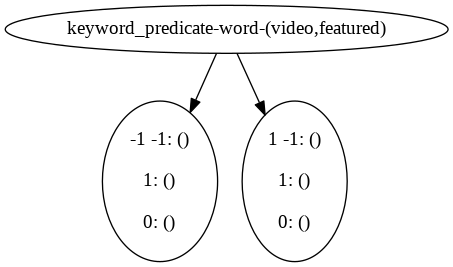

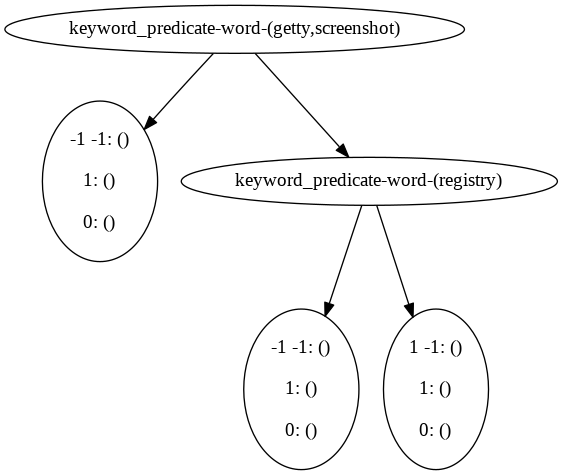

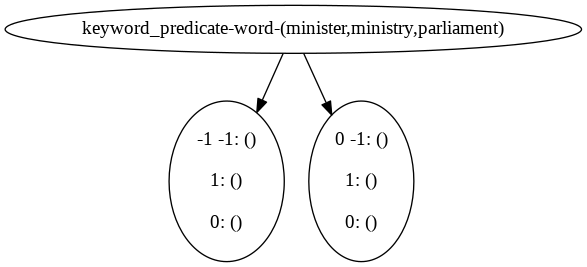

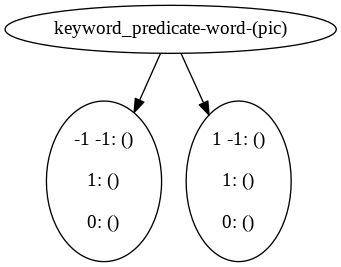

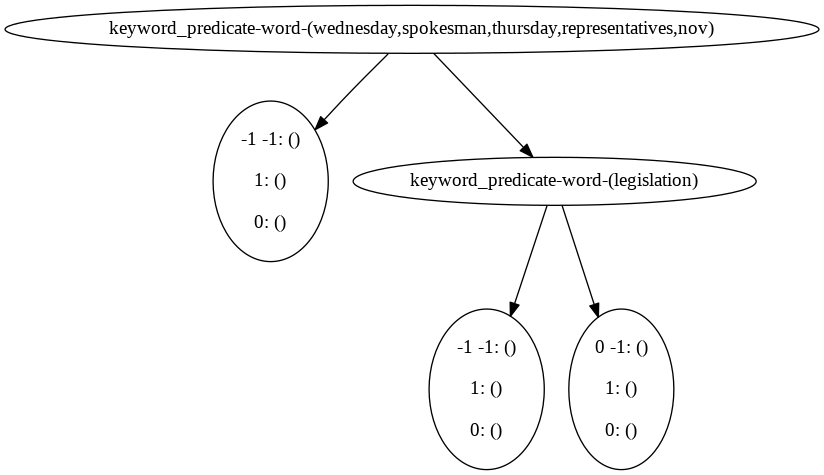

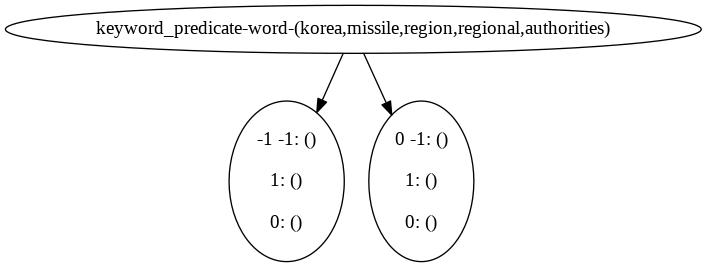

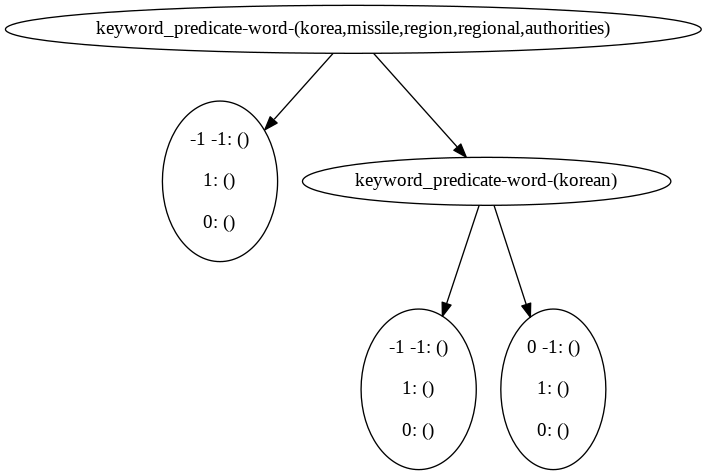

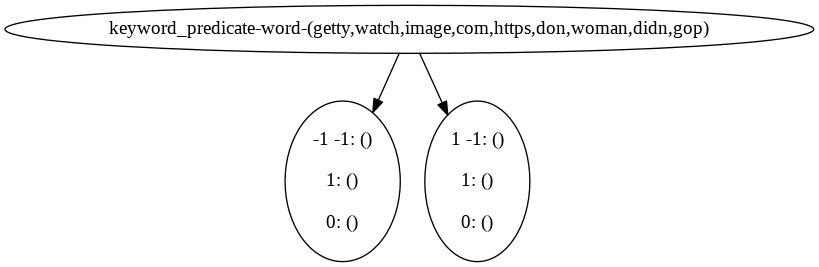

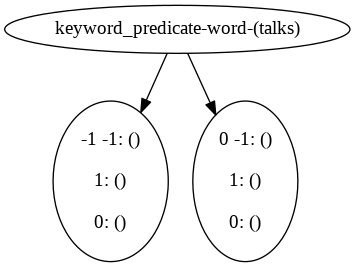

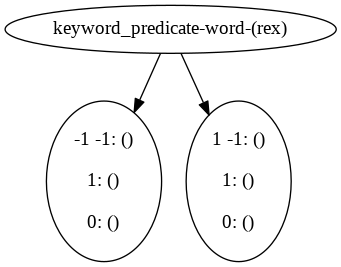

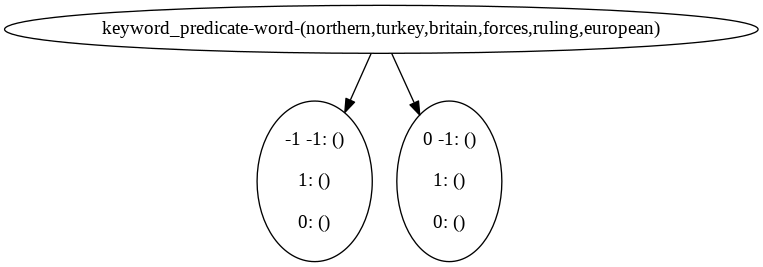

In [5]:
for at in fnews_funcs:
    dot_string = at.gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [6]:
# get the user input 

# from rbbm_src.labelling_func_src.src.utils import lf_constraint_solve
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM, ABSTAIN, PredicateNode
from rbbm_src.labelling_func_src.src.LFRepair import populate_violations, fix_rules_with_solver_input
from rbbm_src.labelling_func_src.src.classes import clean_text

import re
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
import pulp
from sklearn.metrics import accuracy_score, classification_report

from rbbm_src.labelling_func_src.src.KeyWordRuleMiner import KeyWordRuleMiner 
# sample user confirmation and complaints
import random
from collections import deque
import numpy as np
import pickle
import pydot
from IPython.display import Image, display 

import datetime

[nltk_data] Downloading package words to /home/opc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/opc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-10-17 21:28:26.201837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 21:28:26.254979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 21:28:26.256271: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
DEBUG 2024-10-17 21:28:27,114 [tpu_cluster_resolver.py:<module>:32] Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install c

In [7]:
def run_snorkel_with_funcs(dataset_name, funcs, conn):
    
    sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
    sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
    sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
    sentences_df = sentences_df[~sentences_df['text'].isna()]
    applier = PandasLFApplier(lfs=funcs)
    initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
    model = LabelModel(cardinality=2, verbose=True, device='cpu')
    model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)
    probs_test= model.predict_proba(L=initial_vectors)
    df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal  = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
    )	

    df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
    prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
    prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
    df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
    df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
    df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

    wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]
    # df_sentences_filtered.to_csv('predictions_shakira.csv', index=False)
    # logger.critical(wrong_preds)
    global_accuray_on_valid=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

    print(f"""
        out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
        make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
        accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)
    
    global_accuracy = (len(df_sentences_filtered)-len(wrong_preds))/len(sentences_df)
    
    
    ground_truth = df_sentences_filtered['expected_label']
    snorkel_predictions = df_sentences_filtered['model_pred']
    snorkel_probs = df_sentences_filtered['model_pred_diff']
    df_sentences_filtered['vectors'] = pd.Series([",".join(map(str, t)) for t in filtered_vectors])
    correct_predictions = (snorkel_predictions == ground_truth)
    incorrect_predictions = (snorkel_predictions != ground_truth)
    correct_preds_by_snorkel = df_sentences_filtered[correct_predictions].reset_index(drop=True)
    wrong_preds_by_snorkel = df_sentences_filtered[incorrect_predictions].reset_index(drop=True)
    
    return df_sentences_filtered, correct_preds_by_snorkel, wrong_preds_by_snorkel, filtered_vectors, correct_predictions, incorrect_predictions, global_accuracy, global_accuray_on_valid 

In [8]:
def select_user_input(user_confirm_size,
                     user_complaint_size,
                     random_state,
                     filtered_vectors,
                     correct_preds_by_snorkel,
                     wrong_preds_by_snorkel,
                      correct_predictions,
                      incorrect_predictions ):

    user_confirm_df = correct_preds_by_snorkel.sample(n=user_confirm_size, random_state=random_state)
    user_complaints_df = wrong_preds_by_snorkel.sample(n=user_complaint_size, random_state=random_state)
    
    random_confirm_indices = user_confirm_df.index
    random_complaints_indices = user_complaints_df.index
    random_user_confirms_vecs = filtered_vectors[correct_predictions][random_confirm_indices]
    random_user_complaints_vecs = filtered_vectors[incorrect_predictions][random_complaints_indices]
    user_input_df = pd.concat([user_confirm_df, user_complaints_df])
    gts = user_input_df['expected_label'].reset_index(drop=True)
    user_vecs = np.vstack((random_user_confirms_vecs, random_user_complaints_vecs))
    
    return user_vecs, gts, user_input_df


In [9]:
def gather_used_keywords(tree_rules):
    
    used_keywords = []
    
    for atui in tree_rules:
        rids = set([])
        queue = deque([atui.root])
        while(queue):
            cur_node = queue.popleft()
            if(isinstance(cur_node, PredicateNode)):
                used_keywords.extend(cur_node.pred.keywords)
            if(cur_node.left):
                queue.append(cur_node.left)
            if(cur_node.right):
                queue.append(cur_node.right)
    
    return used_keywords

In [10]:
def apply_new_lfs_to_df(new_funcs, user_input_df):
    new_rules_applier = PandasLFApplier(lfs=new_funcs)
    new_rules_vector = new_rules_applier.apply(df=user_input_df, progress_bar=False)
    
    return new_rules_vector

In [11]:
def construct_input_df_to_solver(user_vecs, gts):
    
#     df_new_vectors = pd.DataFrame(new_rules_vector, columns=[f'nlf_{i+1}' for i in range(new_rules_vector.shape[1])])
    df_user_vectors = pd.DataFrame(user_vecs, columns=[f'lf_{i+1}' for i in range(user_vecs.shape[1])])
    combined_df= pd.concat([df_user_vectors, gts], axis=1)
    
    return combined_df

In [12]:
def main_driver(user_input_size,
         lf_acc_thresh,
         instance_acc_thresh,
         min_non_abstain_thresh,
        dataset_name,
        random_state,
        funcs_dictionary,
       instance_acc_on_valid,
       use_non_abstain):
    
    
    run_times = ['snorkel_first_run','snorkel_run_after_fix', 'solver_runtime','repair_time']
    runtime_dict = {r:0 for r in run_times}

    gen_input_tree_rules_func = funcs_dictionary[dataset_name]
    
    conn = psycopg2.connect(dbname='label', user='postgres')
    
    user_complaint_size = math.floor(user_input_size * 0.5)
    user_confirm_size = user_input_size - user_complaint_size
     
    treerules_for_user_input = gen_input_tree_rules_func()
    
    treerules = gen_input_tree_rules_func()
    
    funcs = [f.gen_label_rule() for f in treerules]
    
    first_snorkel_run_start = time.time()
    df_sentences_filtered, correct_preds_by_snorkel, wrong_preds_by_snorkel, filtered_vectors, correct_predictions, incorrect_predictions, global_accuracy, global_accuracy_on_valid =run_snorkel_with_funcs(dataset_name=dataset_name, funcs=funcs, conn=conn)
    first_snorkel_run_end = time.time()
    first_snorkel_run_time = first_snorkel_run_end - first_snorkel_run_start
    runtime_dict['snorkel_first_run'] = first_snorkel_run_time

    user_vecs, gts, user_input_df = select_user_input(user_confirm_size, user_complaint_size, random_state,
                      filtered_vectors,correct_preds_by_snorkel,
                      wrong_preds_by_snorkel, correct_predictions, incorrect_predictions)

        
    combined_df = construct_input_df_to_solver(user_vecs, gts)
    
    return combined_df, user_input_df, global_accuracy

In [13]:
dataset_dict = {
#     "plots": gen_plots_funcs,
#     "amazon": gen_amazon_funcs,
#     "dbpedia": gen_dbpedia_funcs,
#     "agnews": gen_agnews_funcs,
#     "physician_professor": gen_pp_funcs,
#     "imdb": gen_imdb_funcs,
    "fakenews": gen_fakenews_funcs,
#     "yelp": gen_yelp_funcs,
#     "photographer_journalist": gen_pj_funcs,
#     "professor_teacher": gen_professor_teacher_funcs,
#     "painter_architect": gen_painter_architecht_funcs,
#     "tweets": gen_tweets_funcs,
#     "spam": gen_spam_funcs,
}

In [14]:
def run_main_with_params(user_input_size, lf_acc_thresh, instance_acc_thresh, 
                         min_non_abstain_thresh, random_state, dataset_name, funcs_dictionary,
                         instance_acc_on_valid,use_non_abstain):

    combined_df, user_input, global_accuracy = main_driver(
        user_input_size=user_input_size,
        lf_acc_thresh=lf_acc_thresh,
        instance_acc_thresh=instance_acc_thresh,
        min_non_abstain_thresh=min_non_abstain_thresh,
        random_state=random_state,
        dataset_name=dataset_name,
        funcs_dictionary=funcs_dictionary,
        instance_acc_on_valid=instance_acc_on_valid,
       use_non_abstain=use_non_abstain)
    
    print(f"global accuracy: {global_accuracy}")
    
    return user_input


In [15]:
def test_main_with_timeout(params_list, time_limit_minutes):
    time_limit_seconds = time_limit_minutes * 60
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for params in params_list:
            future = executor.submit(run_main_with_params, *params)
            try:
                result = future.result(timeout=time_limit_seconds)
                print(f"Params {params} finished successfully.")
                results.append(result)
            except concurrent.futures.TimeoutError:
                print(f"Params {params} exceeded the time limit, moving to the next set.")
    
    return results

In [16]:
user_input_sizes = [40]
random_states = [1]
lf_acc_threshs = [0.7]
instance_acc_threshs = [0.8]
non_abstain_threshs = [0.8]
datasets = list(dataset_dict)
func_dictionary = [dataset_dict]
instance_acc_on_valids=[True]
use_non_abstains=[True]


In [17]:
import itertools
import concurrent.futures
import time
import math

In [18]:
input_params = list(itertools.product(
    user_input_sizes,
    lf_acc_threshs,
    instance_acc_threshs,
    non_abstain_threshs,
    random_states,
    datasets,
    func_dictionary,
    instance_acc_on_valids,
    use_non_abstains
))


In [19]:
input_params

[(40,
  0.7,
  0.8,
  0.8,
  1,
  'fakenews',
  {'fakenews': <function rbbm_src.labelling_func_src.src.example_tree_rules.gen_fakenews_funcs()>},
  True,
  True)]

In [20]:
user_df = test_main_with_timeout(input_params, time_limit_minutes=20)

/tmp/ipykernel_15283/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:28:48,086 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:28:48,097 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 753.73epoch/s]
INFO 2024-10-17 21:28:48,766 [label_model.py:fit:977] Finished Training



        out of 44236 sentences, 42444 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 11111 wrong predictions, 

        accuracy = 0.7382197719347846 
    
global accuracy: 0.708314494981463
Params (40, 0.7, 0.8, 0.8, 1, 'fakenews', {'fakenews': <function gen_fakenews_funcs at 0x7f1dc0c47940>}, True, True) finished successfully.


In [21]:
gpt_cids = user_df[0]['cid'].to_list()

In [22]:
len(user_df)

1

In [23]:
import pickle

In [24]:
with open('Oct15_night_run/Oct-15-all-datasets-instance_acc_on_valid-use_non_abstain-fakenews_sample_params_40-0.7-0.8-0.8-1-20241016_071332.pkl', 'rb') as f:
    rulecleaner_input = pickle.load(f)

In [25]:
rulecleaner_cids = rulecleaner_input['fix_details']['original_0']['user_input']['cid'].to_list()

In [26]:
len([x for x in gpt_cids if x not in rulecleaner_cids])

0

In [27]:
input_to_chatgpt = user_df[0][['text','expected_label']]

In [28]:
input_to_chatgpt.to_csv('chatgpt_fakenews_userinput.csv', index=False)

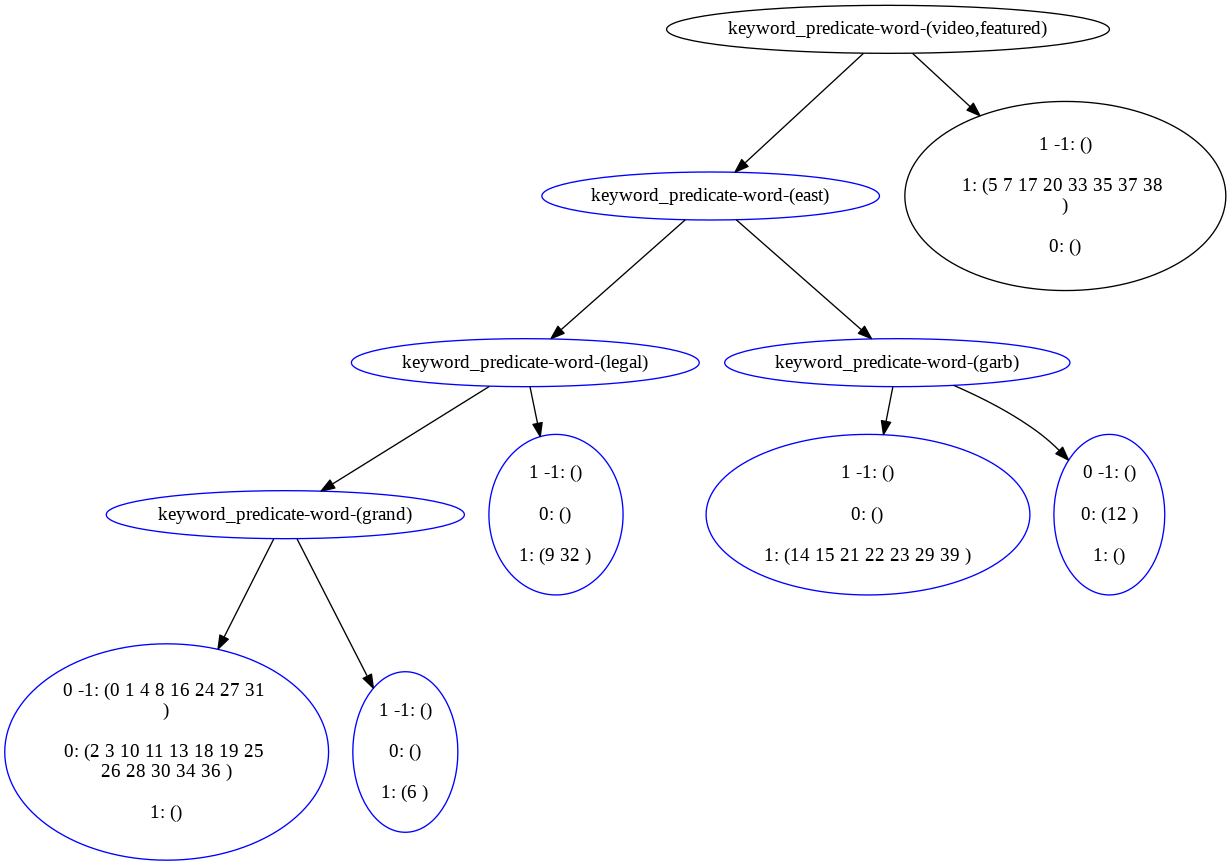

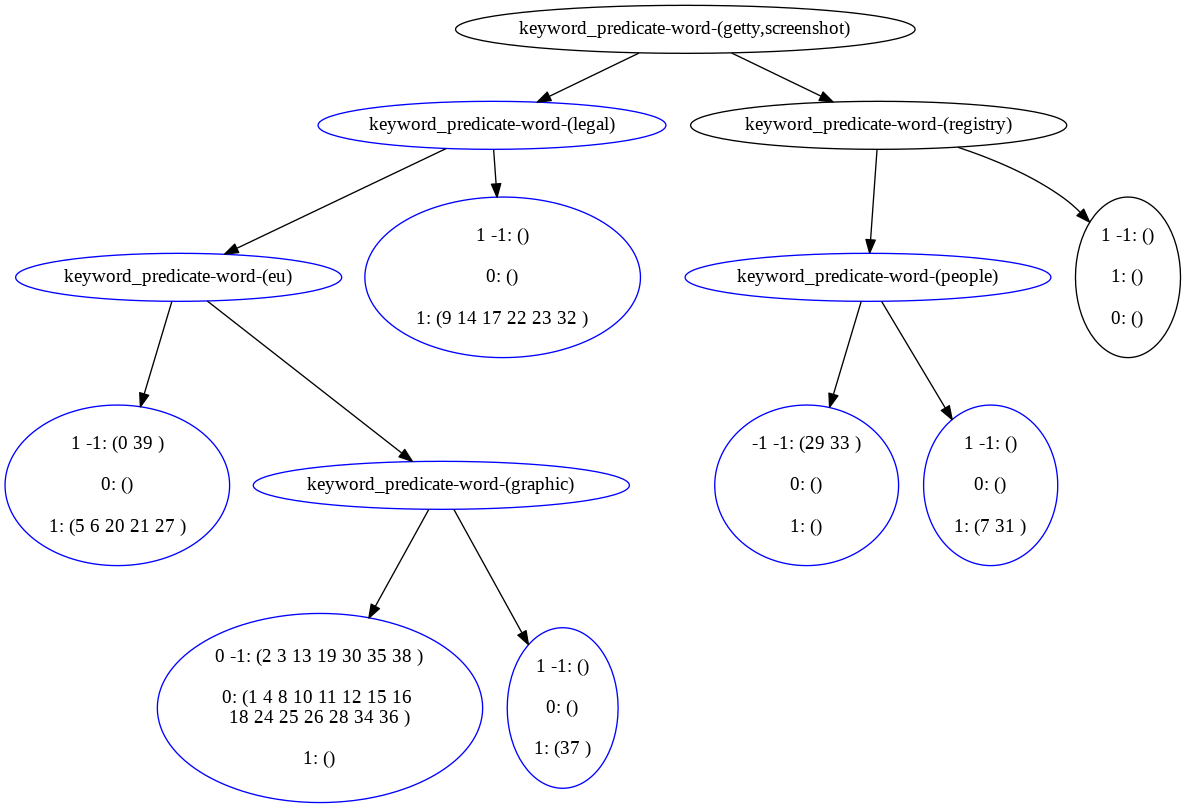

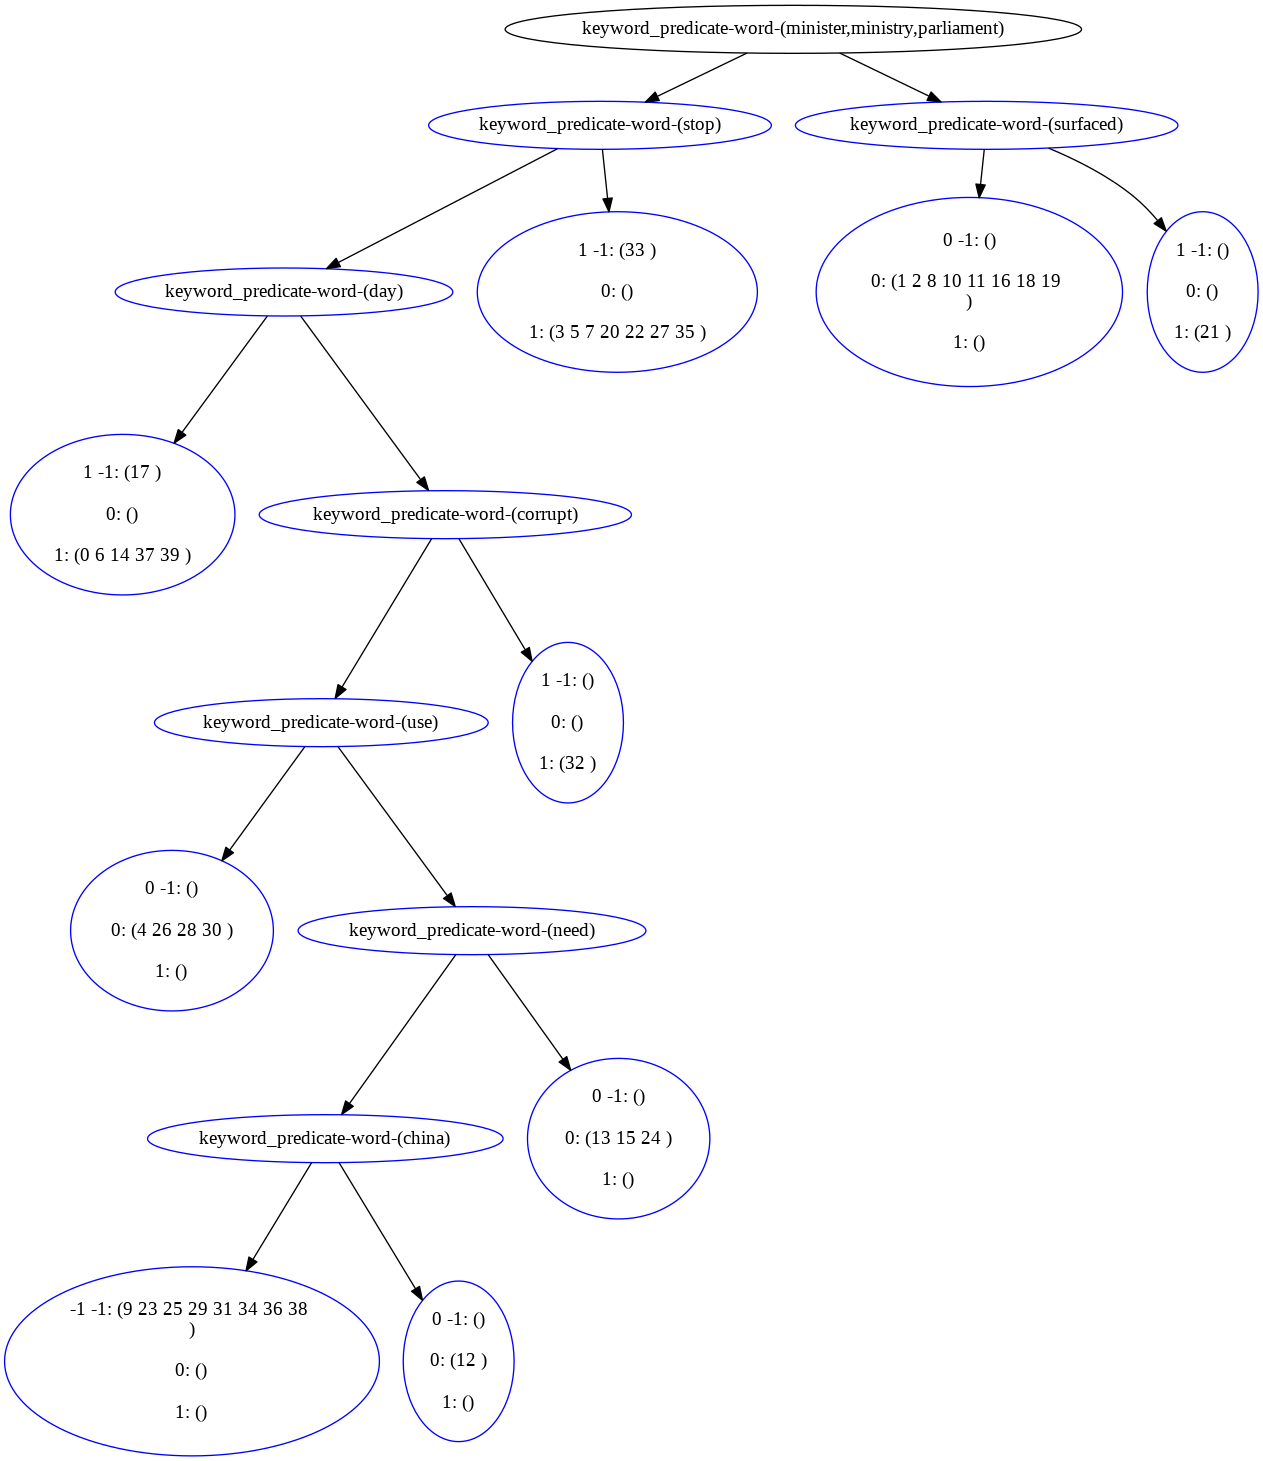

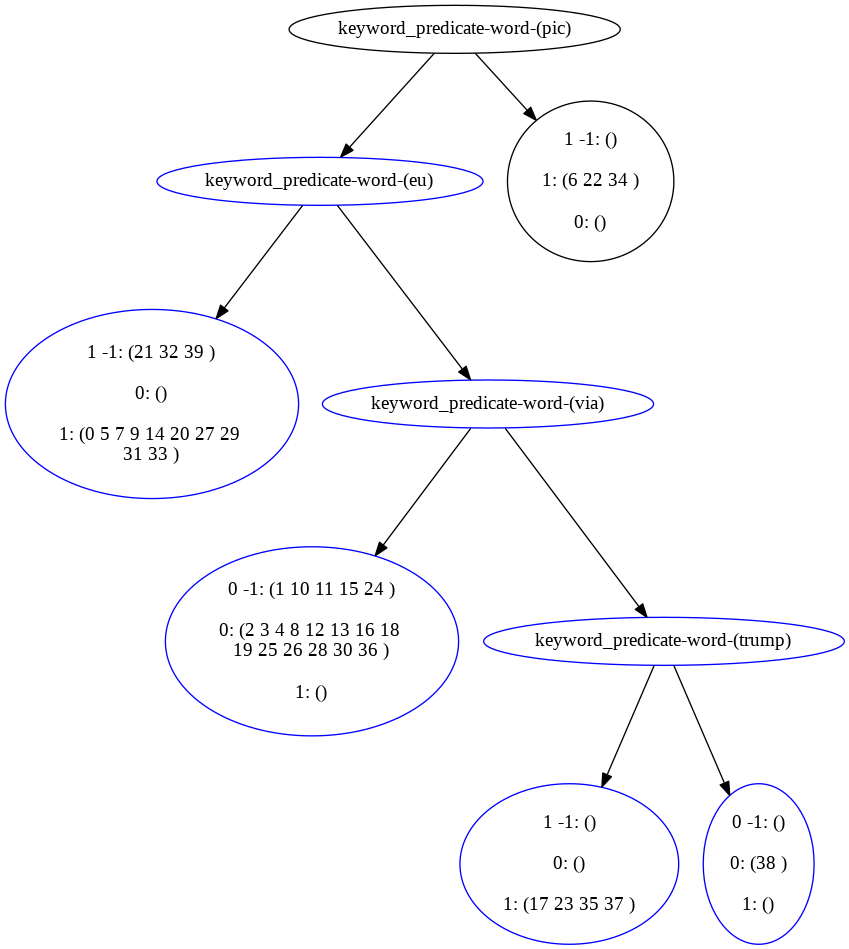

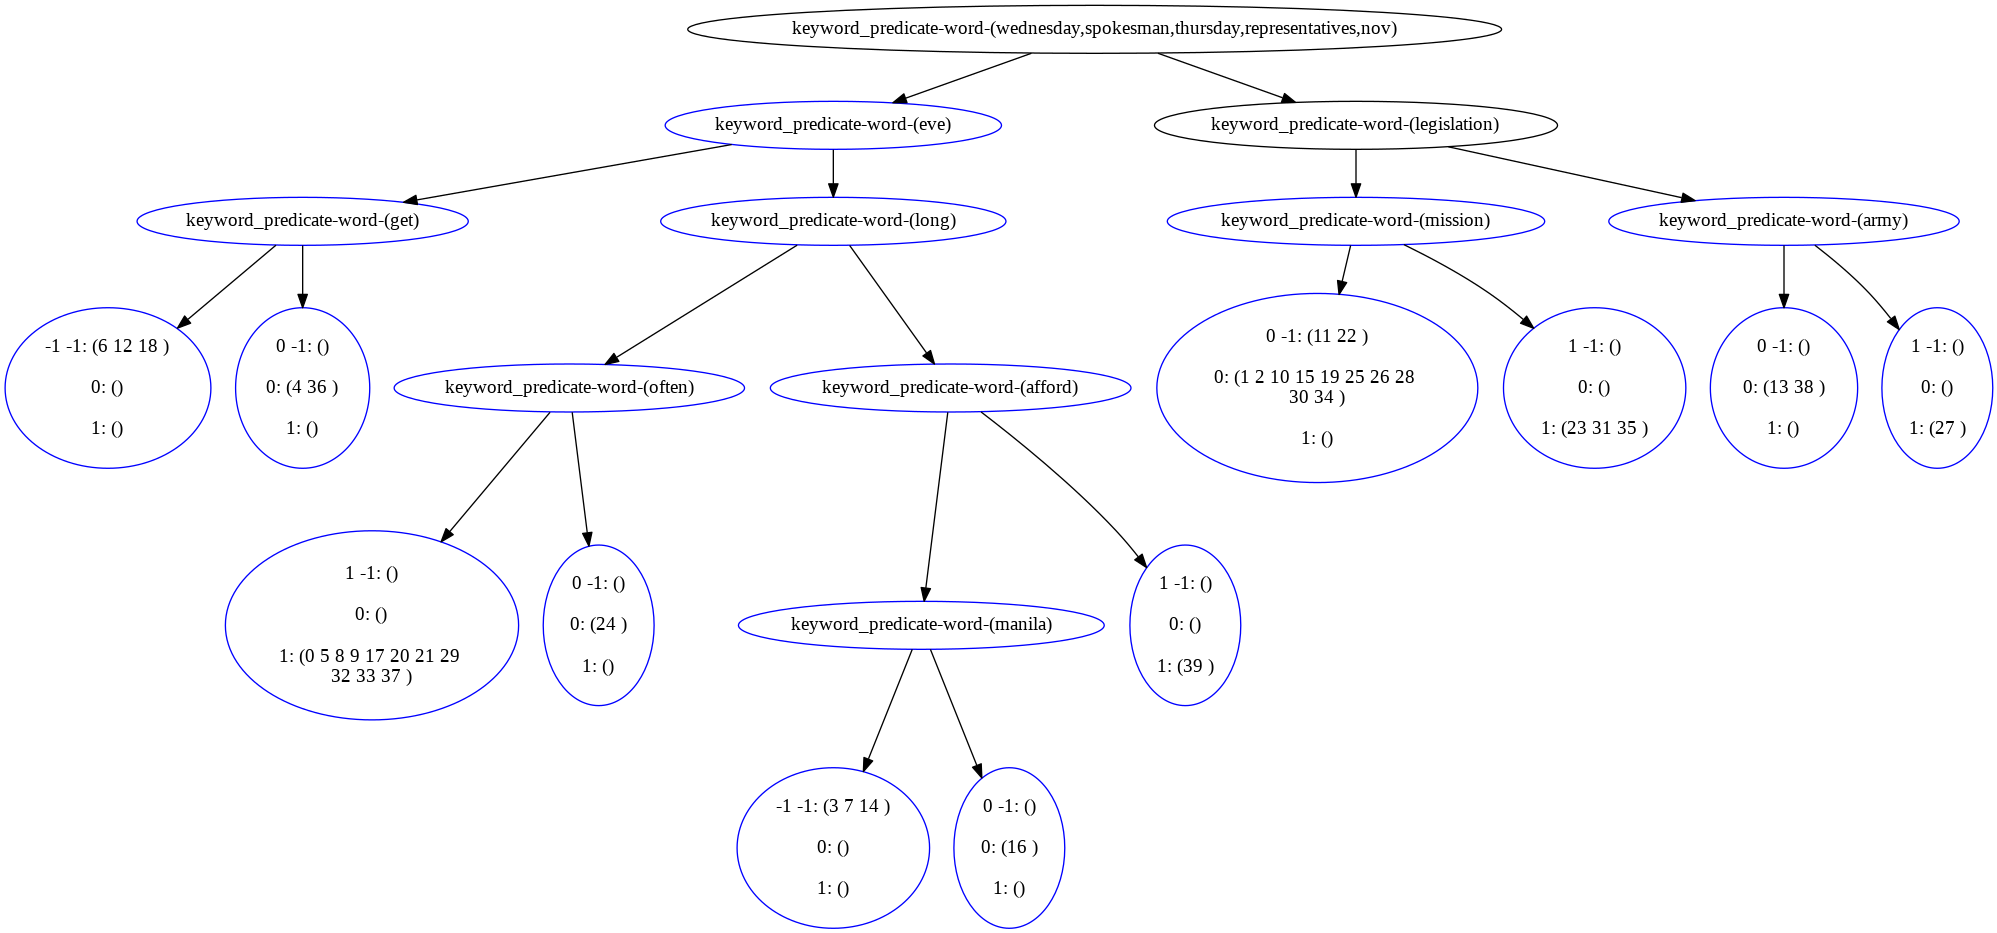

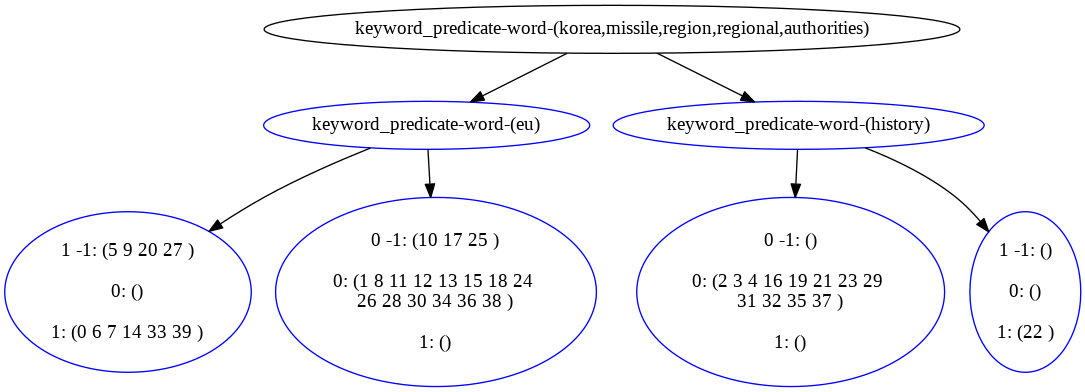

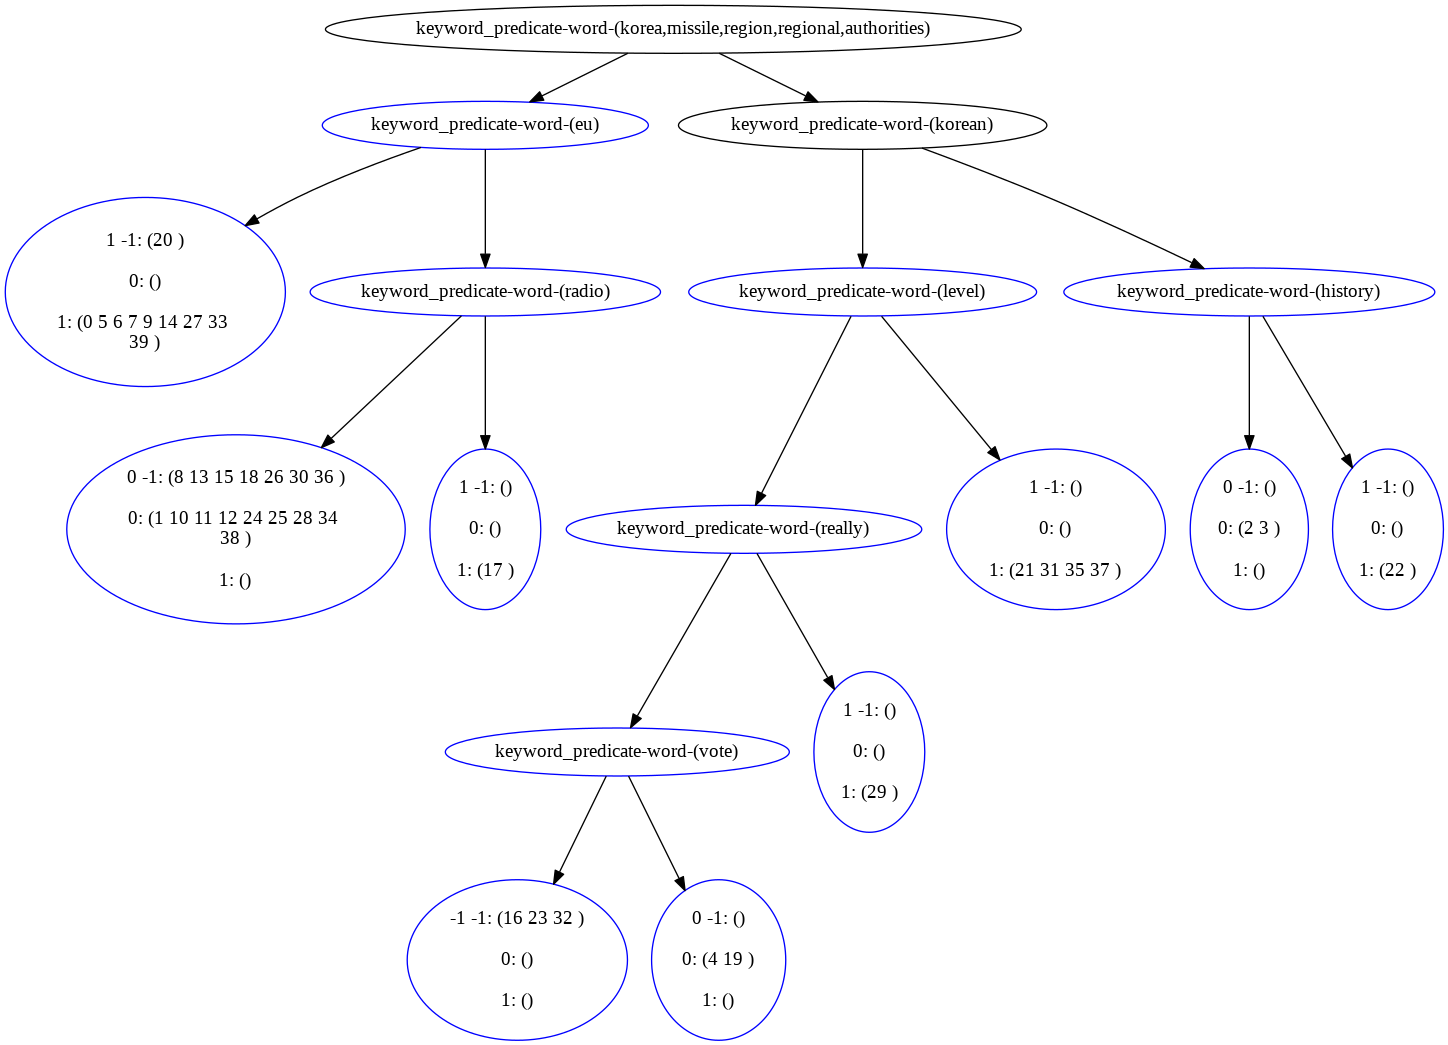

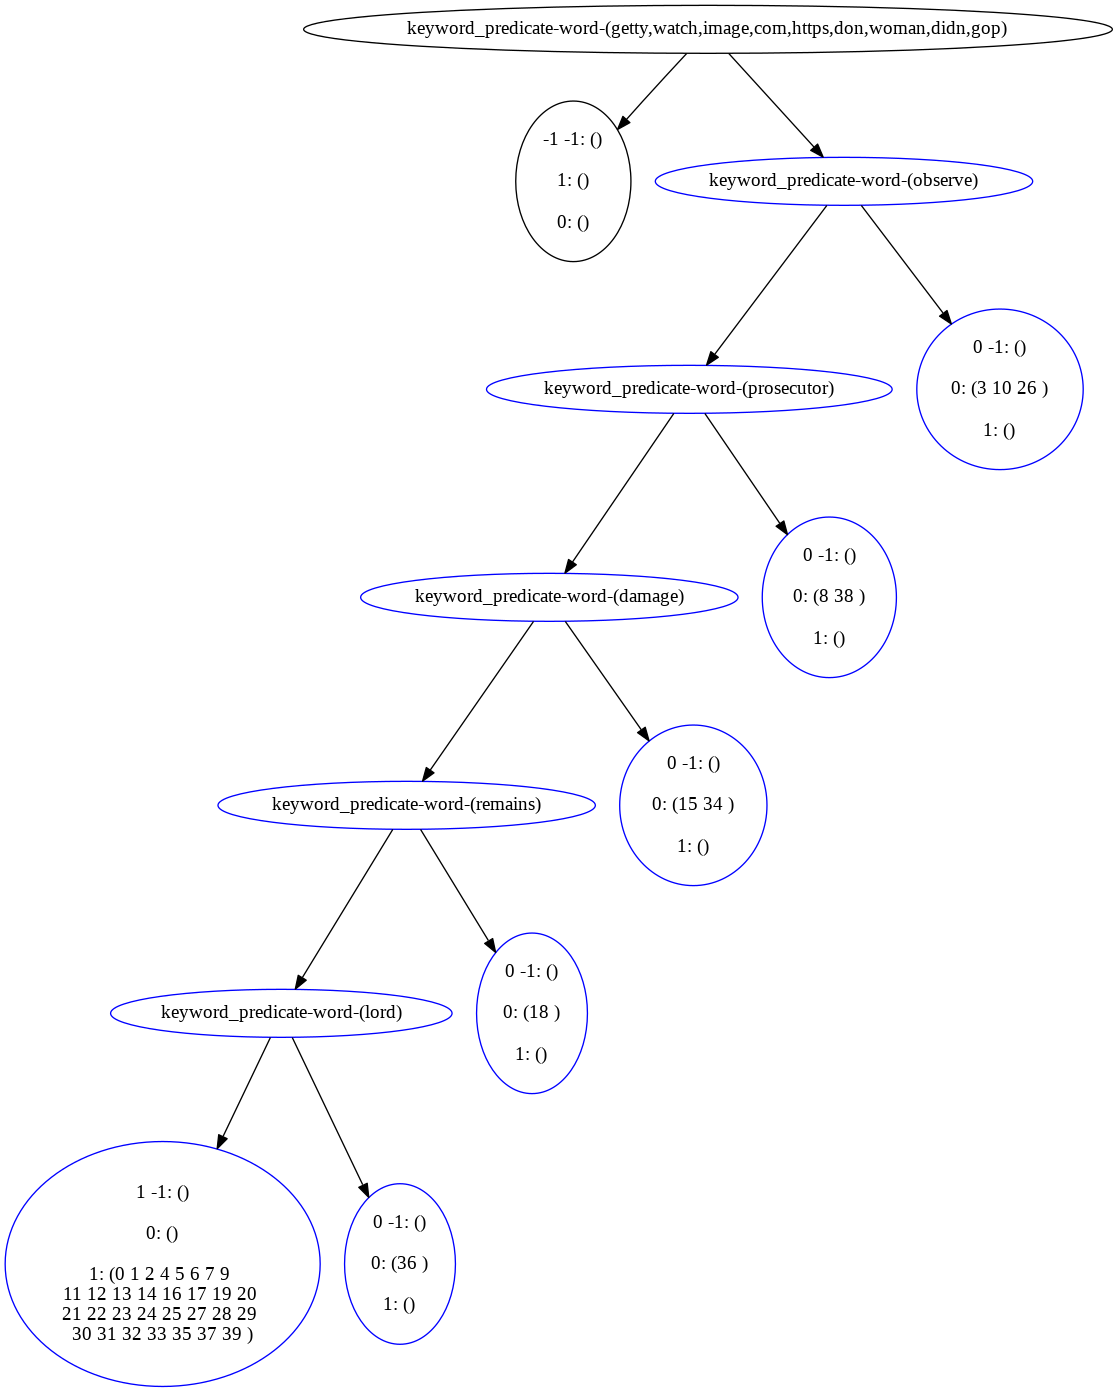

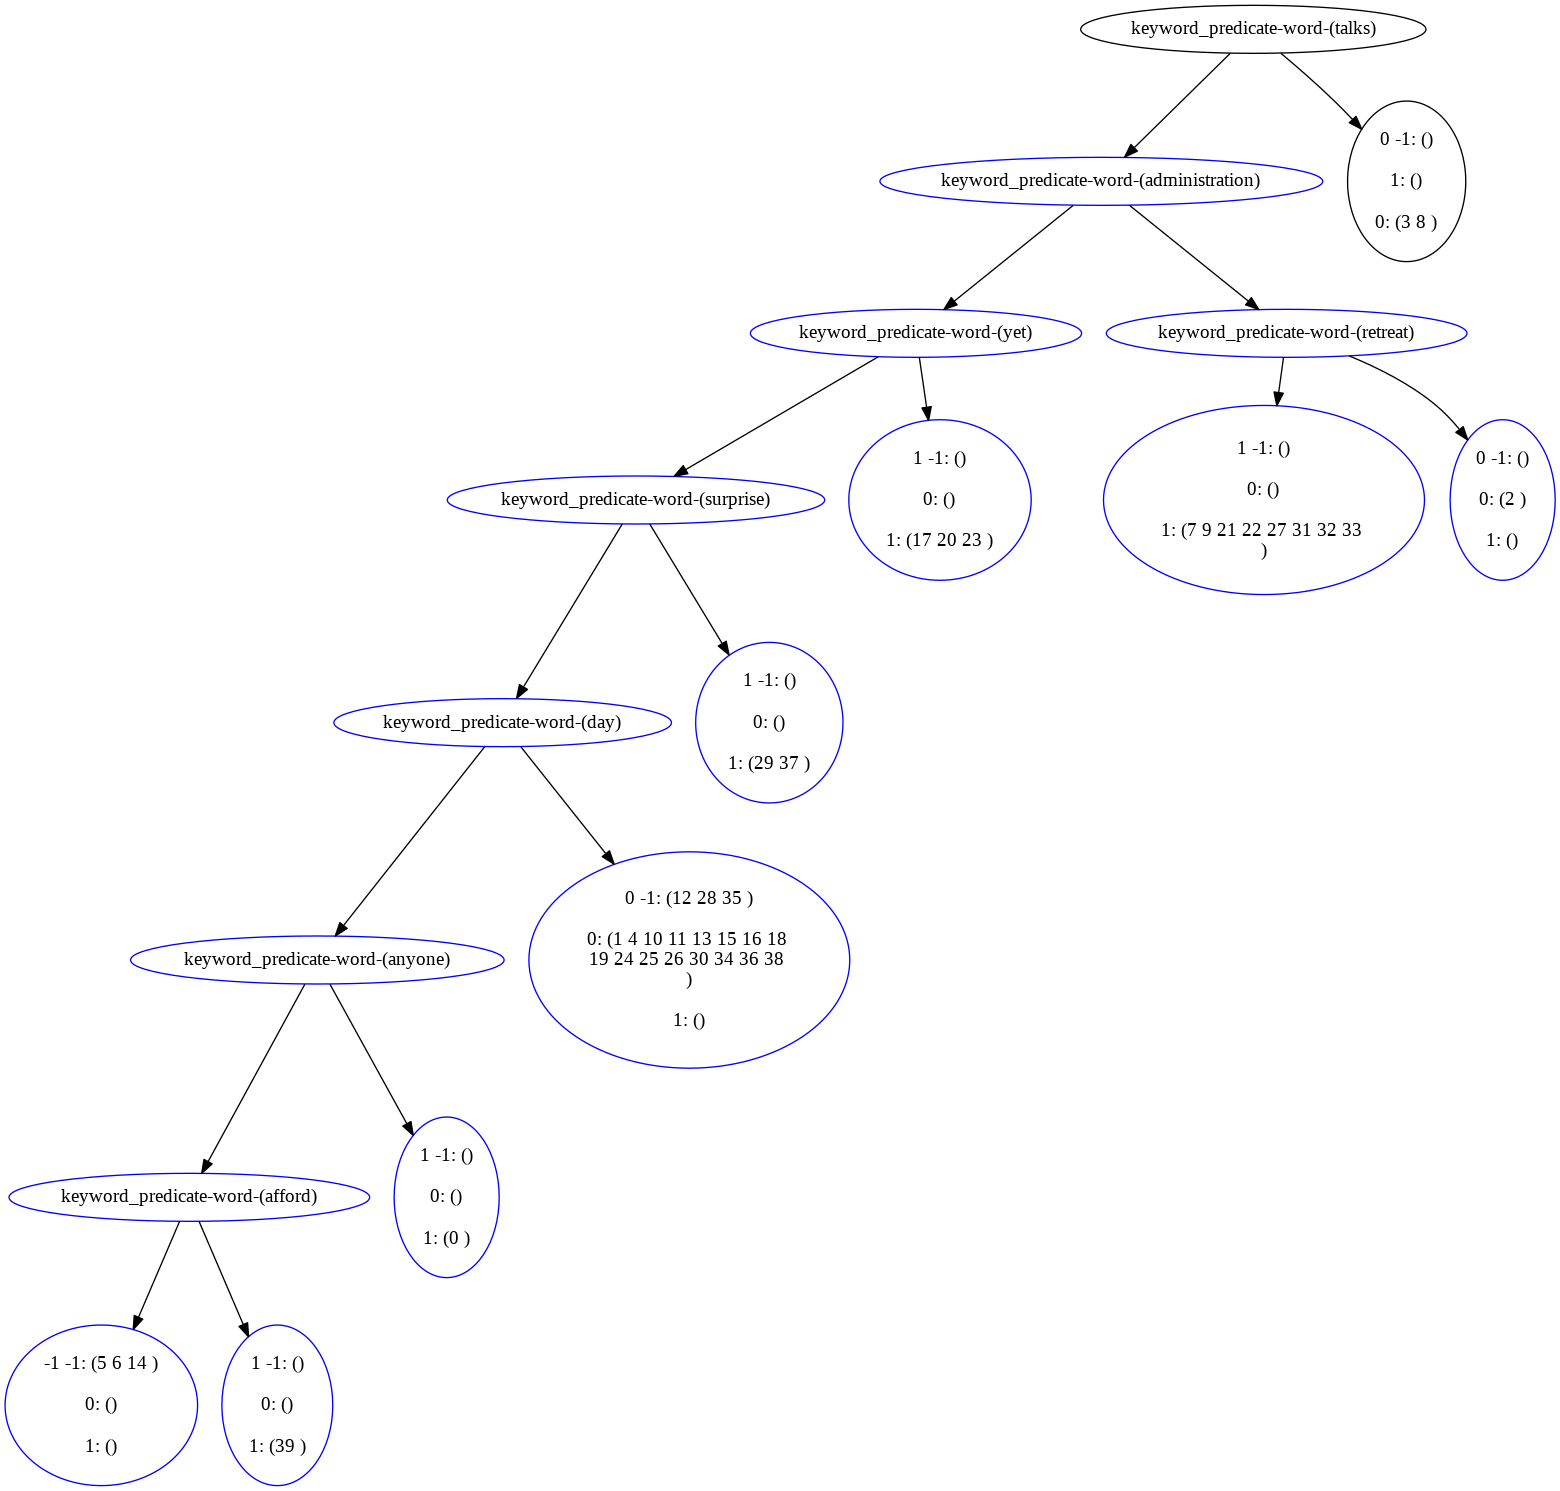

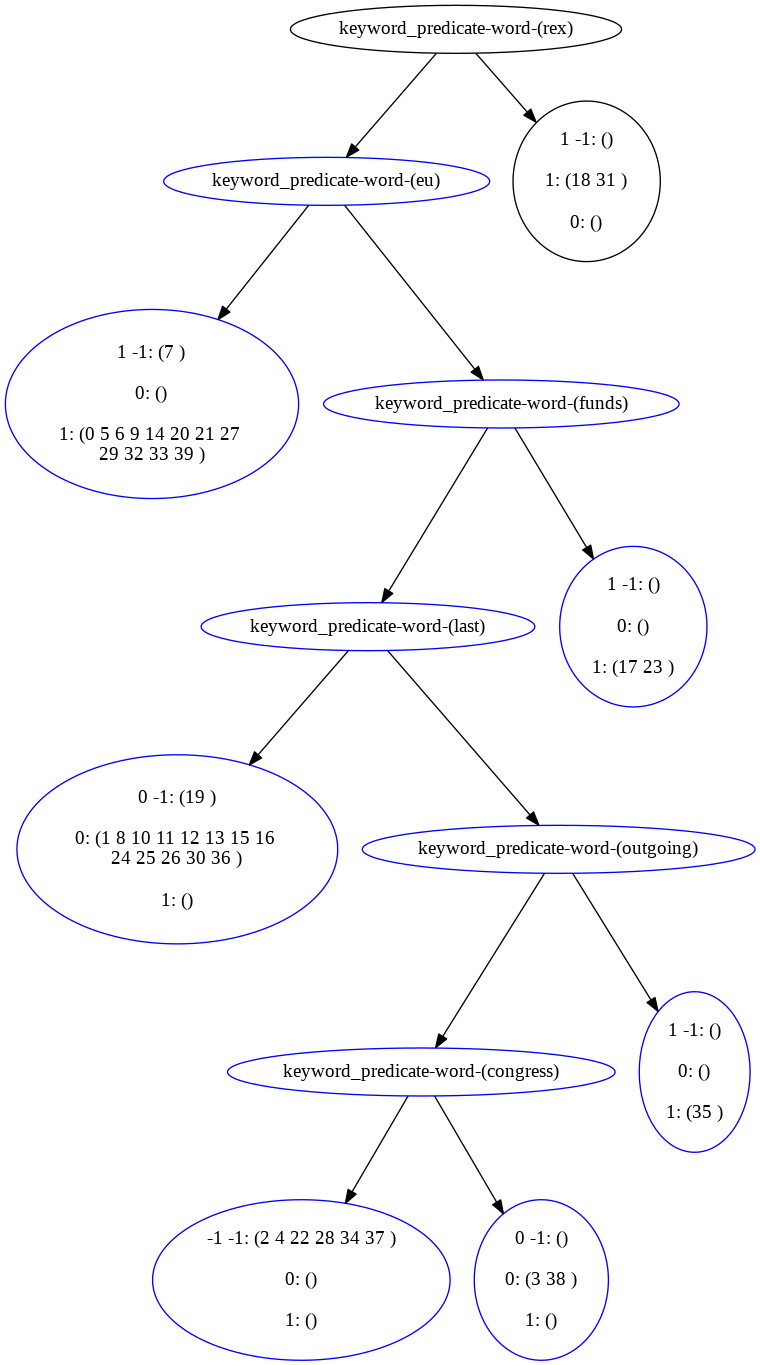

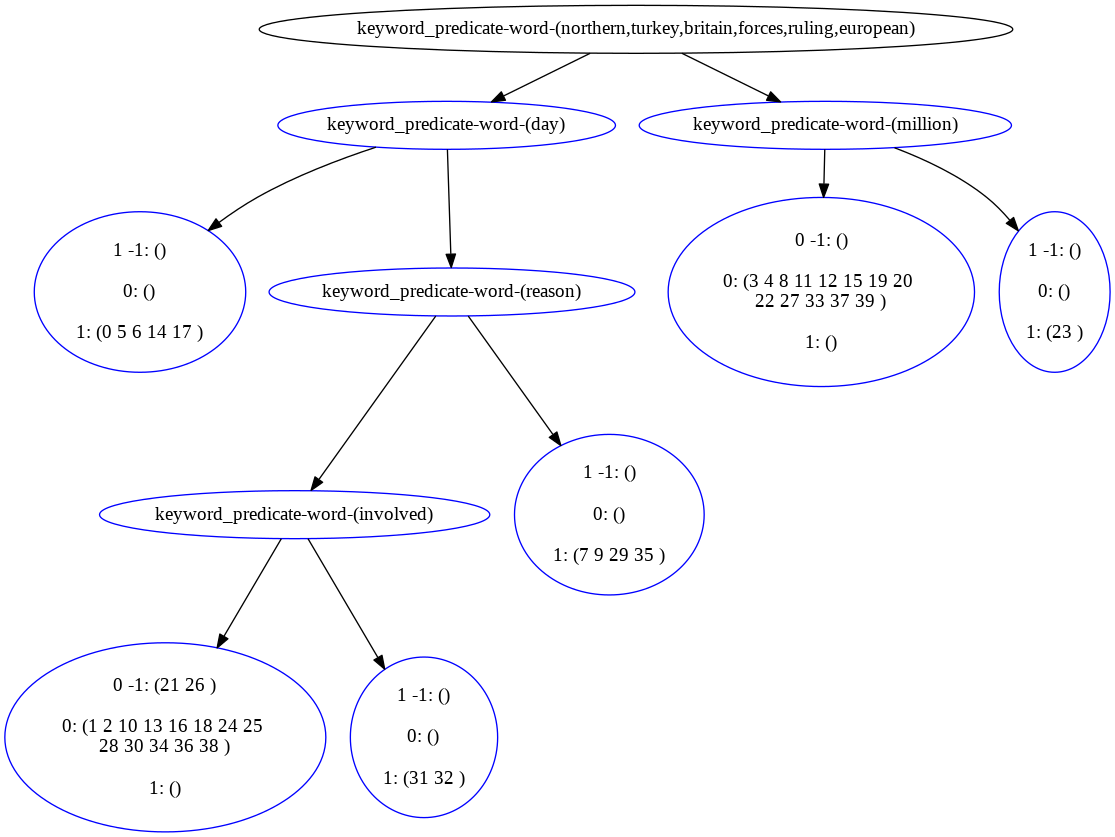

In [29]:
for r in rulecleaner_input['fix_details']:
    dot_string = rulecleaner_input['fix_details'][r]['rule'].gen_dot_string('')
    graph = pydot.graph_from_dot_data(dot_string)[0]
    plt = Image(graph.create_png())
    display(plt)

In [32]:
chatgpt_refined_fakenews_tree_rules = gen_gpt_refined_fakenews_funcs_user_input_40()
chatgpt_refined_fakenews_tree_funcs = [f.gen_label_rule() for f in chatgpt_refined_fakenews_tree_rules]
conn = psycopg2.connect(dbname='label', user='postgres')


In [33]:
new_df_sentences_filtered, new_correct_preds_by_snorkel, new_wrong_preds_by_snorkel, new_filtered_vectors, new_correct_predictions, \
    new_incorrect_predictions, new_global_accuracy, new_global_accuracy_on_valid = run_snorkel_with_funcs(dataset_name='fakenews', funcs=chatgpt_refined_fakenews_tree_funcs, conn=conn)


/tmp/ipykernel_15283/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:48:39,344 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:48:39,356 [label_model.py:fit:911] Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 966.27epoch/s]
INFO 2024-10-17 21:48:39,878 [label_model.py:fit:977] Finished Training



        out of 44236 sentences, 43578 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 7578 wrong predictions, 

        accuracy = 0.8261049153242461 
    


In [38]:
new_global_accuracy

0.8138168007957319

In [34]:
rule_cleaner_refined_trees = [rulecleaner_input['fix_details'][x]['rule'] for x in rulecleaner_input['fix_details']]

In [35]:
rule_cleaner_refined_funcs = [f.gen_label_rule() for f in rule_cleaner_refined_trees]

In [36]:
new_df_sentences_filtered_from_rc, new_correct_preds_by_snorkel_from_rc, new_wrong_preds_by_snorkel_from_rc, new_filtered_vectors_from_rc, new_correct_predictions_from_rc, \
    new_incorrect_predictions_from_rc, new_global_accuracy_from_rc, new_global_accuracy_on_valid_from_rc = run_snorkel_with_funcs(dataset_name='fakenews', funcs=rule_cleaner_refined_funcs, conn=conn)


/tmp/ipykernel_15283/1538512102.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM {dataset_name}', conn)
INFO 2024-10-17 21:52:38,578 [label_model.py:fit:905] Computing O...
INFO 2024-10-17 21:52:38,589 [label_model.py:fit:911] Estimating \mu...
 60%|██████████████████████████████████████████████████▍                                 | 300/500 [00:00<00:00, 863.48epoch/s]INFO 2024-10-17 21:52:39,023 [logger.py:log:79] [300 epochs]: TRAIN:[loss=0.089]
INFO 2024-10-17 21:52:39,110 [logger.py:log:79] [400 epochs]: TRAIN:[loss=0.089]
100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 806.61epoch/s]
INFO 2024-10-17 21:52:39,214 [label_model.py:fit:977] Finished Training



        out of 44236 sentences, 44236 actually got at least one signal to 

        make prediction. Out of all the valid predictions, we have 3516 wrong predictions, 

        accuracy = 0.9205172257889501 
    


In [37]:
new_global_accuracy_from_rc

0.9205172257889501

In [39]:
confirm_cids = user_df[0][user_df[0]['expected_label']==user_df[0]['model_pred']]['cid'].to_list()
complaint_cids = user_df[0][user_df[0]['expected_label']!=user_df[0]['model_pred']]['cid'].to_list()

In [40]:
# chat gpt confirm preserv and fix rate
df_confirms_after_fix = new_df_sentences_filtered[(new_df_sentences_filtered['cid'].isin(confirm_cids))]
df_complaints_after_fix = new_df_sentences_filtered[(new_df_sentences_filtered['cid'].isin(complaint_cids))]

confirm_preserv_rate = len(df_confirms_after_fix[df_confirms_after_fix['expected_label']==df_confirms_after_fix['model_pred']])/len(df_confirms_after_fix)
complain_fix_rate = len(df_complaints_after_fix[df_complaints_after_fix['expected_label']==df_complaints_after_fix['model_pred']])/len(df_complaints_after_fix)


In [42]:
confirm_preserv_rate

0.9

In [43]:
complain_fix_rate

0.65

In [44]:
# rc confirm preserv and fix rate
df_confirms_after_fix = new_df_sentences_filtered_from_rc[(new_df_sentences_filtered_from_rc['cid'].isin(confirm_cids))]
df_complaints_after_fix = new_df_sentences_filtered_from_rc[(new_df_sentences_filtered_from_rc['cid'].isin(complaint_cids))]

confirm_preserv_rate_rc = len(df_confirms_after_fix[df_confirms_after_fix['expected_label']==df_confirms_after_fix['model_pred']])/len(df_confirms_after_fix)
complain_fix_rate_rc = len(df_complaints_after_fix[df_complaints_after_fix['expected_label']==df_complaints_after_fix['model_pred']])/len(df_complaints_after_fix)


In [45]:
confirm_preserv_rate_rc

1.0

In [46]:
complain_fix_rate_rc

1.0